In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import backend as K


# ============================================
# Cargar dataset
# ============================================
df = pd.read_csv("/Datasets/solar_merged_clean.csv")

# ============================================
# Crear transformaciones geograficas
# ============================================

# convertir grados a radianes
df["lat_rad"] = np.radians(df["lat"])
df["lon_rad"] = np.radians(df["lon"])

df["sin_lat"] = np.sin(df["lat_rad"])
df["cos_lat"] = np.cos(df["lat_rad"])
df["sin_lon"] = np.sin(df["lon_rad"])
df["cos_lon"] = np.cos(df["lon_rad"])

# ============================================
# Crear transformaciones temporales
# ============================================
df["date"] = pd.to_datetime(df["date"], errors="coerce")

df["dayofyear"] = df["date"].dt.dayofyear
df["dayofyear_norm"] = df["dayofyear"] / 365.0

df["sin_doy"] = np.sin(2 * np.pi * df["dayofyear"] / 365.0)
df["cos_doy"] = np.cos(2 * np.pi * df["dayofyear"] / 365.0)

# ============================================
# Variables derivadas
# ============================================

# lag 1 del target
df["surface_net_solar_radiation_sum_lag1"] = (
    df["surface_net_solar_radiation_sum"].shift(1)
)

# indice combinando temp y humedad
df["temp_humidity_index"] = (
    df["temperature_2m_C"] * (df["relative_humidity"] / 100.0)
)

# razon entre nubes y presion
df["cloud_pressure_ratio"] = (
    df["Cloud_Cover_Mean_24h"] / df["surface_pressure"]
)

# eliminar filas con NaN creados por el lag
df = df.dropna()

# ============================================
# Seleccionar features finales
# ============================================
feature_cols = [
    "Cloud_Cover_Mean_24h",
    "relative_humidity",
    "temperature_2m_C",
    "total_precipitation_sum",
    "surface_pressure",
    "elevation",
    "sin_lat",
    "cos_lat",
    "sin_lon",
    "cos_lon",

    "sin_doy",
    "cos_doy",
    "dayofyear_norm",

    "surface_net_solar_radiation_sum_lag1",
    "temp_humidity_index",
    "cloud_pressure_ratio"
]

target_col = "surface_net_solar_radiation_sum"

X = df[feature_cols]
y = df[target_col].values

# ============================================
# Split train / val / test
# ============================================
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

# ============================================
# Escalar
# ============================================
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ============================================
# Normalizar target
# ============================================
y_mean = y_train.mean()
y_std = y_train.std()

y_train_n = (y_train - y_mean) / y_std
y_val_n = (y_val - y_mean) / y_std
y_test_n = (y_test - y_mean) / y_std


# ================================
# Build model
# ================================
def build_model(input_dim):

    model = models.Sequential()

    # capa inicial
    model.add(layers.Dense(
        128,
        kernel_regularizer=regularizers.l2(1e-6),
        input_shape=(input_dim,)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("gelu"))

    # bloque 1
    model.add(layers.Dense(
        256,
        kernel_regularizer=regularizers.l2(1e-6)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("gelu"))
    model.add(layers.Dropout(0.1))

    # bloque 2 tipo residual
    model.add(layers.Dense(
        256,
        kernel_regularizer=regularizers.l2(1e-6)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("gelu"))

    model.add(layers.Dense(
        128,
        kernel_regularizer=regularizers.l2(1e-6)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("gelu"))
    model.add(layers.Dropout(0.05))

    # bloque final
    model.add(layers.Dense(64, activation="gelu"))
    model.add(layers.Dense(32, activation="gelu"))

    model.add(layers.Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
        loss="mse",
        metrics=["mae"]
    )

    return model



model = build_model(X_train_scaled.shape[1])

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=20, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=8,
        min_lr=1e-6
    )
]


# ================================
# Train model
# ================================
history = model.fit(
    X_train_scaled,
    y_train_n,
    validation_data=(X_val_scaled, y_val_n),
    epochs=300,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
806/806 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.2975 - mae: 0.4134 - val_loss: 0.1881 - val_mae: 0.3259 - learning_rate: 3.0000e-04
Epoch 2/300
806/806 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2017 - mae: 0.3408 - val_loss: 0.1585 - val_mae: 0.2987 - learning_rate: 3.0000e-04
Epoch 3/300
806/806 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1754 - mae: 0.3185 - val_loss: 0.1351 - val_mae: 0.2743 - learning_rate: 3.0000e-04
Epoch 4/300
806/806 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1618 - mae: 0.3055 - val_loss: 0.1206 - val_mae: 0.2614 - learning_rate: 3.0000e-04
Epoch 5/300
806/806 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1461 - mae: 0.2905 - val_loss: 0.1130 - val_mae: 0.2510 - learning_rate: 3.0000e-04
Epoch 6/300
806/806 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1359 - mae: 0.2800 - val_loss: 0.1045 - val_mae: 0.2420 - learning_rate: 3.0000e-04
Epoch 7/300
806/806 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1300 - mae: 0.2737 - val_loss: 0.0992 - val_mae: 0.23

In [ ]:
model.save("solar_model.keras")
import joblib
joblib.dump(scaler, "solar_scaler.pkl")


['solar_scaler.pkl']

403/403 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
===== METRICAS REALES DEL MODELO =====
MAE real : 334064.76246466924
RMSE real: 479379.41741120286
R2 real  : 0.980617448630675
MAPE (%) : 32.41255809904362


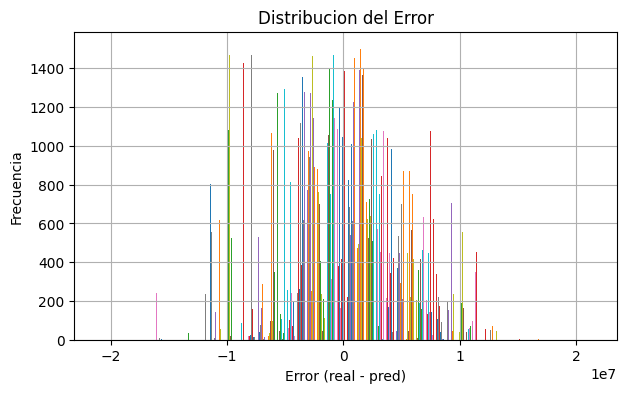

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ============================================
# Predicciones normalizadas
# ============================================
y_pred_n = model.predict(X_test_scaled)

# ============================================
# Des-normalizar (volver a la escala real)
# ============================================
y_pred = y_pred_n * y_std + y_mean
y_real = y_test_n * 0  # evitar errores si no existe
y_real = y_test  # los valores reales ya estan sin normalizar

# ============================================
# Metricas reales
# ============================================
mae_real = mean_absolute_error(y_real, y_pred)
rmse_real = np.sqrt(mean_squared_error(y_real, y_pred))
r2_real = r2_score(y_real, y_pred)
mape_real = np.mean(np.abs((y_real - y_pred) / (y_real + 1e-6))) * 100

print("===== METRICAS REALES DEL MODELO =====")
print("MAE real :", mae_real)
print("RMSE real:", rmse_real)
print("R2 real  :", r2_real)
print("MAPE (%) :", mape_real)

# ============================================
# Grafico: Real vs Pred
# ============================================
plt.figure(figsize=(6,6))
plt.scatter(y_real, y_pred, s=4)
min_val = min(y_real.min(), y_pred.min())
max_val = max(y_real.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "--")
plt.xlabel("Real")
plt.ylabel("Prediccion")
plt.title("Real vs Prediccion")
plt.grid()
plt.show()

# ============================================
# Distribucion del error
# ============================================
error = y_real - y_pred

plt.figure(figsize=(7,4))
plt.hist(error, bins=50)
plt.title("Distribucion del Error")
plt.xlabel("Error (real - pred)")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()
